In [2]:
!pip install elasticsearch

!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

import findspark
findspark.init()

     |████████████████████████████████| 102kB 2.3MB/s 


In [3]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image, HTML, display
from elasticsearch import Elasticsearch

from pyspark.sql.types import *
from pyspark.sql.functions import col, mean, udf, lit, current_timestamp, unix_timestamp, array_contains

from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
link_ratings = 'https://drive.google.com/file/d/1GPyMA3DWQtFJh5EUQ_ZR8XEIn2NIqwbe/view?usp=sharing'
link_movies = 'https://drive.google.com/file/d/1i9tAKBsGAM14be7R8MS_i4Pee6uFnYZF/view?usp=sharing'
link_links = 'https://drive.google.com/file/d/1UPfD0J9xE-qV7UEBhWh-fGgv4GxGwvZR/view?usp=sharing'

In [0]:
id = '1GPyMA3DWQtFJh5EUQ_ZR8XEIn2NIqwbe'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('ratings.csv')  
raw_ratings = pd.read_csv('ratings.csv')

id = '1i9tAKBsGAM14be7R8MS_i4Pee6uFnYZF'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('movies.csv')  
raw_movies = pd.read_csv('movies.csv')

id = '1UPfD0J9xE-qV7UEBhWh-fGgv4GxGwvZR'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('links.csv')  
raw_links = pd.read_csv('links.csv')

In [0]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [0]:
ratings_df = spark.createDataFrame(raw_ratings)
movies_df = spark.createDataFrame(raw_movies)
links_df = spark.createDataFrame(raw_links)

In [8]:
print(ratings_df.printSchema())
print(movies_df.printSchema())
print(links_df.printSchema())

root
 |-- userId: long (nullable = true)
 |-- movieId: long (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: long (nullable = true)

None
root
 |-- movieId: long (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)

None
root
 |-- movieId: long (nullable = true)
 |-- imdbId: long (nullable = true)
 |-- tmdbId: double (nullable = true)

None


In [13]:
# display(ratings.show(5))
ratings_df.show(5)

# number of users
ratings_df.select('userID').distinct().count()

# number of movies
movies_df.select('movieID').distinct().count()

# number of movies rated by users
ratings_df.select('movieID').distinct().count() 

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
|     1|     47|   5.0|964983815|
|     1|     50|   5.0|964982931|
+------+-------+------+---------+
only showing top 5 rows



9724

In [0]:
ratings_df.createOrReplaceTempView("ratings_view")
movies_df.createOrReplaceTempView("movies_view")

# List movies not rated before
spark.sql(
    '''SELECT DISTINCT movieID 
       FROM movies_view 
       WHERE movieID NOT IN (SELECT DISTINCT movieID FROM ratings_view)
    ''').show()

'''
reference: 
https://stackoverflow.com/questions/40244925/filter-dataframe-by-value-not-present-in-column-of-other-dataframe
'''

In [0]:
set(movies_df.select('genres').rdd.flatMap(tuple).collect())
# set(movies.select('genres').rdd.collect())
# set(movies.select('genres').rdd.flatMap(tuple).flatMap(tuple).collect())
genres_set = set(movies_df.select('genres').rdd.flatMap(tuple).flatMap(tuple).collect())
genres_set

In [11]:
from pyspark.sql.functions import explode,split
movies_df = movies_df.withColumn("genre",explode(split(movies_df.genres,'[|]')))   
# '\\|' or [|]
movies_df.show(5)

+-------+----------------+--------------------+---------+
|movieId|           title|              genres|    genre|
+-------+----------------+--------------------+---------+
|      1|Toy Story (1995)|Adventure|Animati...|Adventure|
|      1|Toy Story (1995)|Adventure|Animati...|Animation|
|      1|Toy Story (1995)|Adventure|Animati...| Children|
|      1|Toy Story (1995)|Adventure|Animati...|   Comedy|
|      1|Toy Story (1995)|Adventure|Animati...|  Fantasy|
+-------+----------------+--------------------+---------+
only showing top 5 rows



In [12]:
genres_set = set(movies_df.select("genre").rdd.flatMap(tuple).collect())
genres_set

{'(no genres listed)',
 'Action',
 'Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'IMAX',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western'}

In [13]:
# key: genre name, value: a DataFrame that is of this genre
d = {}
for genre in genres_set:
    d[genre] = movies_df.select('movieID').where(array_contains(split(movies_df.genres,'\\|'), genre)).collect()

print(len(d['War']))
d['Action'][:5]

1092


[Row(movieID=6),
 Row(movieID=6),
 Row(movieID=6),
 Row(movieID=9),
 Row(movieID=10)]

In [14]:
rating_count = ratings_df.groupBy("rating").count().sort("count",ascending = True)
rating_count.show()

+------+-----+
|rating|count|
+------+-----+
|   0.5| 1370|
|   1.5| 1791|
|   1.0| 2811|
|   2.5| 5550|
|   2.0| 7551|
|   4.5| 8551|
|   3.5|13136|
|   5.0|13211|
|   3.0|20047|
|   4.0|26818|
+------+-----+



In [15]:
from pyspark.sql.functions import mean, avg, count, round
rating_avg = ratings_df.groupBy("movieId").agg(avg("rating").cast("float").alias("rating_avg")).sort("rating_avg",ascending = False)
rating_avg.show(5)

+-------+----------+
|movieId|rating_avg|
+-------+----------+
| 147286|       5.0|
|   5241|       5.0|
| 172587|       5.0|
|  95149|       5.0|
| 173355|       5.0|
+-------+----------+
only showing top 5 rows



In [17]:
avgRating_freq = rating_avg.groupBy("rating_avg").count().select(round(rating_avg.rating_avg,2).alias("rating_avg"),"count")
avgRating_freq.show(5)

# print(ratings.count())
# ratings.cache()
# print(ratings.schema)

+----------+-----+
|rating_avg|count|
+----------+-----+
|       5.0|  296|
|       4.9|    1|
|      4.83|    2|
|      4.75|   29|
|       4.7|    1|
+----------+-----+
only showing top 5 rows



In [18]:
# cast timestamp to milliseconds to be consistent with the requirement of elasticsearch
ratings_df = ratings_df.select(ratings_df.userId, ratings_df.movieId, ratings_df.rating, (ratings_df.timestamp.cast("long") * 1000).alias("timestamp"))
ratings_df.show(5)

+------+-------+------+------------+
|userId|movieId|rating|   timestamp|
+------+-------+------+------------+
|     1|      1|   4.0|964982703000|
|     1|      3|   4.0|964981247000|
|     1|      6|   4.0|964982224000|
|     1|     47|   5.0|964983815000|
|     1|     50|   5.0|964982931000|
+------+-------+------+------------+
only showing top 5 rows



In [19]:
ratings_df.groupBy('rating').count().toPandas()

,rating,count
0,3.5,13136
1,4.5,8551
2,2.5,5550
3,1.0,2811
4,4.0,26818
5,0.5,1370
6,3.0,20047
7,2.0,7551
8,1.5,1791
9,5.0,13211


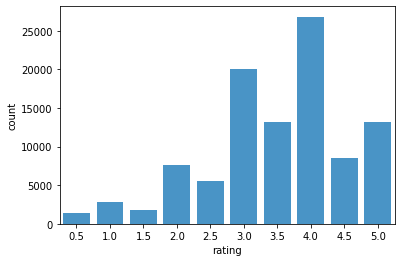

In [26]:
sns.barplot(x = "rating", y = "count", color = '#3498db', data = ratings_df.groupBy('rating').count().toPandas())
plt.savefig('fig_001.png', dpi=600)

In [27]:
# averaeg rating per movie
ratings_df.groupBy('MovieID').agg(round(mean('rating'),2).alias("rating_avg")).toPandas().head()

,MovieID,rating_avg
0,2529,3.80
1,60756,3.55
2,474,3.69
3,26,3.50
4,72011,3.72


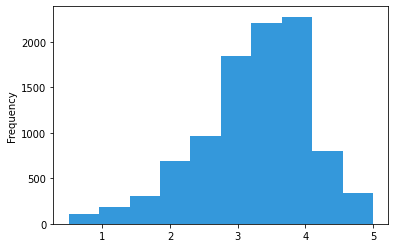

In [28]:
ratings_df.groupBy('MovieID').agg(mean('rating')).toPandas()['avg(rating)'].plot(kind='hist', color='#3498db')
plt.savefig('fig_002.png', dpi=600)

In [23]:
# average rating from users
ratings_df.groupBy('userID').agg(mean('rating')).toPandas().head()

,userID,avg(rating)
0,26,3.238095
1,29,4.141975
2,474,3.398956
3,65,4.029412
4,191,3.741176


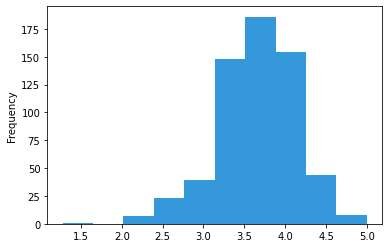

In [29]:
# average rating from users
ratings_df.groupBy('userID').agg(mean('rating')).toPandas()['avg(rating)'].plot(kind='hist', color='#3498db')
plt.savefig('fig_003.png', dpi=600)

In [20]:
movies_df.show(5,truncate = False)

+-------+----------------+-------------------------------------------+---------+
|movieId|title           |genres                                     |genre    |
+-------+----------------+-------------------------------------------+---------+
|1      |Toy Story (1995)|Adventure|Animation|Children|Comedy|Fantasy|Adventure|
|1      |Toy Story (1995)|Adventure|Animation|Children|Comedy|Fantasy|Animation|
|1      |Toy Story (1995)|Adventure|Animation|Children|Comedy|Fantasy|Children |
|1      |Toy Story (1995)|Adventure|Animation|Children|Comedy|Fantasy|Comedy   |
|1      |Toy Story (1995)|Adventure|Animation|Children|Comedy|Fantasy|Fantasy  |
+-------+----------------+-------------------------------------------+---------+
only showing top 5 rows



In [21]:
# define a UDF to convert the raw genres string to an array of genres and lowercase
extract_genres = udf(lambda x: x.lower().split("|"), ArrayType(StringType()))
# test it out
movies_df.select("movieId", "title", extract_genres("genres").alias("genres")).show(5, False)

+-------+----------------+-------------------------------------------------+
|movieId|title           |genres                                           |
+-------+----------------+-------------------------------------------------+
|1      |Toy Story (1995)|[adventure, animation, children, comedy, fantasy]|
|1      |Toy Story (1995)|[adventure, animation, children, comedy, fantasy]|
|1      |Toy Story (1995)|[adventure, animation, children, comedy, fantasy]|
|1      |Toy Story (1995)|[adventure, animation, children, comedy, fantasy]|
|1      |Toy Story (1995)|[adventure, animation, children, comedy, fantasy]|
+-------+----------------+-------------------------------------------------+
only showing top 5 rows



In [22]:
# define a UDF to extract the release year from the title, and return the new title and year in a struct type
def extract_year_fn(title):
    result = re.search("\(\d{4}\)", title)
    try:
        if result:
            group = result.group()
            year = group[1:-1]
            start_pos = result.start()
            title = title[:start_pos-1]
            return (title, year)
        else:
            return (title, 1970)
    except:
        print(title)

extract_year = udf(extract_year_fn,\
                   StructType([StructField("title", StringType(), True),\
                               StructField("release_date", StringType(), True)]))
    
# test out our function
s = "Jumanji (1995)"
extract_year_fn(s)

('Jumanji', '1995')

In [23]:
print(re.search("\(\d{4}\)", s))
print(re.search("\(\d{4}\)", s).start())
print(re.search("\(\d{4}\)", s).group())
print(s[8])

<_sre.SRE_Match object; span=(8, 14), match='(1995)'>
8
(1995)
(


In [24]:
movies_df = movies_df.select(
    "movieId", extract_year("title").title.alias("title"),\
    extract_year("title").release_date.alias("release_date"),\
    extract_genres("genres").alias("genres"))

print("Cleaned movie data:")
movies_df.show(5, truncate = False)

Cleaned movie data:
+-------+---------+------------+-------------------------------------------------+
|movieId|title    |release_date|genres                                           |
+-------+---------+------------+-------------------------------------------------+
|1      |Toy Story|1995        |[adventure, animation, children, comedy, fantasy]|
|1      |Toy Story|1995        |[adventure, animation, children, comedy, fantasy]|
|1      |Toy Story|1995        |[adventure, animation, children, comedy, fantasy]|
|1      |Toy Story|1995        |[adventure, animation, children, comedy, fantasy]|
|1      |Toy Story|1995        |[adventure, animation, children, comedy, fantasy]|
+-------+---------+------------+-------------------------------------------------+
only showing top 5 rows



In [0]:
link_df = spark.createDataFrame(raw_links)
movie_data = movies_df.join(link_df, movies_df.movieId == link_df.movieId)\
    .select(movies_df.movieId, movies_df.title, movies_df.release_date, movies_df.genres, link_df.tmdbId)

In [26]:
num_movies = movie_data.count()
print("Cleaned movie data with tmdbId links:")
movie_data.show(5, truncate=False)

Cleaned movie data with tmdbId links:
+-------+--------------------------------------------------------+------------+--------------------------------------------+-------+
|movieId|title                                                   |release_date|genres                                      |tmdbId |
+-------+--------------------------------------------------------+------------+--------------------------------------------+-------+
|26     |Othello                                                 |1995        |[drama]                                     |16420.0|
|29     |City of Lost Children, The (Cité des enfants perdus, La)|1995        |[adventure, drama, fantasy, mystery, sci-fi]|902.0  |
|29     |City of Lost Children, The (Cité des enfants perdus, La)|1995        |[adventure, drama, fantasy, mystery, sci-fi]|902.0  |
|29     |City of Lost Children, The (Cité des enfants perdus, La)|1995        |[adventure, drama, fantasy, mystery, sci-fi]|902.0  |
|29     |City of Lost Children,

In [0]:
# ALS training
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import CrossValidator,ParamGridBuilder

In [28]:
movie_ratings = ratings_df.drop('timestamp')
movie_ratings.show(5)

+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
|     1|      1|   4.0|
|     1|      3|   4.0|
|     1|      6|   4.0|
|     1|     47|   5.0|
|     1|     50|   5.0|
+------+-------+------+
only showing top 5 rows



In [29]:
# split the data to 80% training and 20% test. Use RMSE as evaluation metrics
(train,test) = movie_ratings.randomSplit([0.8,0.2])
evaluator = RegressionEvaluator(metricName = 'rmse', labelCol = 'rating')

result = []
ranks = [5, 10, 15, 20, 30]
regParams = [0.05, 0.1, 0.15, 0.2, 0.3, 0.5]

for rank in ranks:
  tmp = [] # used to store rmse result for current rank
  for regParam in regParams:
    estimator = ALS(rank = rank, regParam = regParam, maxIter = 20, userCol = 'userId', itemCol = 'movieId', ratingCol = 'rating', coldStartStrategy = 'drop')
    model = estimator.fit(train)
    test_transformed = model.transform(test)
    rmse = evaluator.evaluate(test_transformed)
    print("Test set RMSE (rank = {:2d}, regParam = {:.3f}): {:.3f}".format(rank, regParam,rmse))
    tmp.append(rmse)
  result.append(tmp)

Test set RMSE (rank =  5, regParam = 0.050): 0.924
Test set RMSE (rank =  5, regParam = 0.100): 0.880
Test set RMSE (rank =  5, regParam = 0.150): 0.873
Test set RMSE (rank =  5, regParam = 0.200): 0.880
Test set RMSE (rank =  5, regParam = 0.300): 0.915
Test set RMSE (rank =  5, regParam = 0.500): 1.004
Test set RMSE (rank = 10, regParam = 0.050): 0.937
Test set RMSE (rank = 10, regParam = 0.100): 0.881
Test set RMSE (rank = 10, regParam = 0.150): 0.872
Test set RMSE (rank = 10, regParam = 0.200): 0.879
Test set RMSE (rank = 10, regParam = 0.300): 0.915
Test set RMSE (rank = 10, regParam = 0.500): 1.004
Test set RMSE (rank = 15, regParam = 0.050): 0.941
Test set RMSE (rank = 15, regParam = 0.100): 0.882
Test set RMSE (rank = 15, regParam = 0.150): 0.873
Test set RMSE (rank = 15, regParam = 0.200): 0.880
Test set RMSE (rank = 15, regParam = 0.300): 0.915
Test set RMSE (rank = 15, regParam = 0.500): 1.004
Test set RMSE (rank = 20, regParam = 0.050): 0.946
Test set RMSE (rank = 20, regPa

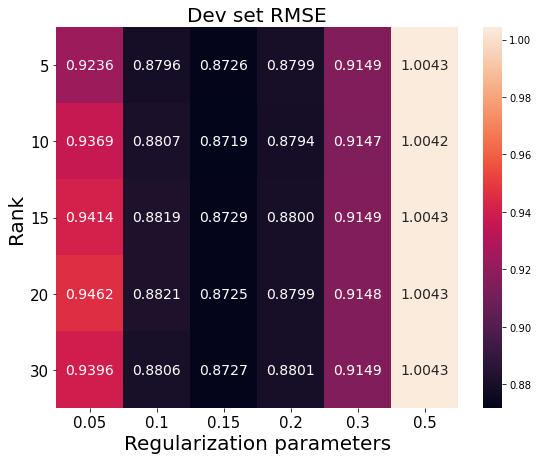

In [30]:
result_df = pd.DataFrame(result, index = ranks, columns = regParams)

fig = plt.figure(figsize = (9,7))
ax = fig.add_subplot(111)
sns.heatmap(result_df, annot = True, fmt = ".4f", ax = ax, annot_kws = {"size": 14})
ax.set_xlabel("Regularization parameters", fontsize = 20)
ax.set_ylabel("Rank", fontsize = 20)
ax.tick_params(labelrotation = 0)
ax.set_title("Dev set RMSE", fontsize = 20)
ax.tick_params(labelsize = 15)

In [31]:
# traing best model using full data set with the best parameter set
best_estimator = ALS(rank = 15, regParam = 0.2, maxIter = 20, userCol = 'userId', itemCol = 'movieId', ratingCol = 'rating', coldStartStrategy = 'drop')
best_model =  best_estimator.fit(movie_ratings)
movie_ratings_transformed = best_model.transform(movie_ratings)
movie_ratings_transformed.cache()
rmse = evaluator.evaluate(movie_ratings_transformed)
print("Full dataset RMSE for best model: {:.3f}".format(rmse))

Full dataset RMSE for best model: 0.724


In [32]:
from pyspark.sql import DataFrame
import pandas as pd
user_recommend = spark.createDataFrame(pd.DataFrame({"userId": [575, 232]}))
user_recommend = best_model.recommendForUserSubset(user_recommend,5)
display(user_recommend.collect())

[Row(userId=232, recommendations=[Row(movieId=3379, rating=4.77566385269165), Row(movieId=59018, rating=4.764034748077393), Row(movieId=60943, rating=4.764034748077393), Row(movieId=67618, rating=4.730528354644775), Row(movieId=33649, rating=4.659862995147705)]),
 Row(userId=575, recommendations=[Row(movieId=141718, rating=5.06446647644043), Row(movieId=3379, rating=5.0169758796691895), Row(movieId=59018, rating=5.003696441650391), Row(movieId=60943, rating=5.003696441650391), Row(movieId=5490, rating=4.892968654632568)])]

In [33]:
movie_recommend = spark.createDataFrame(pd.DataFrame({"movieId": [3379]}))
movie_recommend = best_model.recommendForItemSubset(movie_recommend,5)
display(movie_recommend.collect())

[Row(movieId=3379, recommendations=[Row(userId=53, rating=6.935571193695068), Row(userId=452, rating=6.224073886871338), Row(userId=122, rating=6.1770524978637695), Row(userId=276, rating=6.175344944000244), Row(userId=171, rating=6.129565715789795)])]

In [83]:
userFactors = best_model.userFactors.collect() # dim = 15 = rank
# userFactors[:5]
type(userFactors[0]['features'])
userFactors[0]['id']
# best_model.itemFactors

10

**Elastic Search Move user and movie embedding to ES


Successfully imported tmdbsimple!


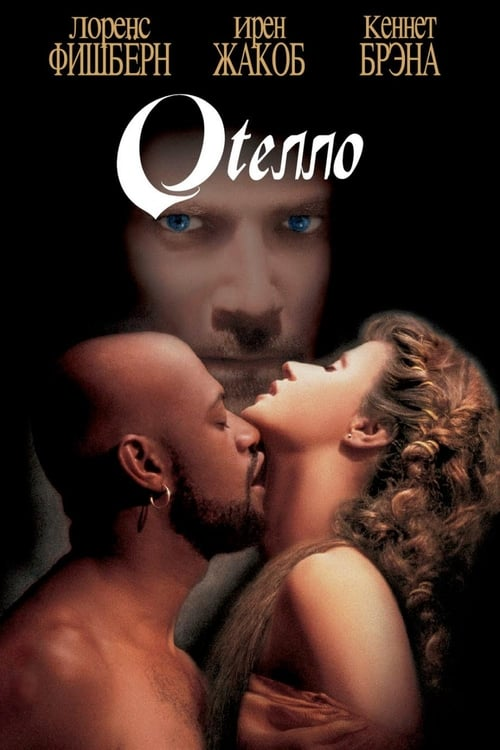

In [36]:
!pip install tmdbsimple
try:
    import tmdbsimple as tmdb
    # replace this variable with your actual TMdb API key
    tmdb.API_KEY = '65ed52ed974ae7b1b2bb5cb8d6d03488'
    API_KEY = '65ed52ed974ae7b1b2bb5cb8d6d03488'
    print("Successfully imported tmdbsimple!")
    # base URL for TMDB poster images
    IMAGE_URL = 'https://image.tmdb.org/t/p/w500'
    movie_id = movie_data.first().tmdbId
    movie_info = tmdb.Movies(movie_id).info()
    movie_poster_url = IMAGE_URL + movie_info['poster_path']
    display(Image(movie_poster_url, width=200))
except Exception:
    print("Cannot import tmdbsimple, no movie posters will be displayed!")

In [0]:
!wget https://artifacts.elastic.co/downloads/elasticsearch/elasticsearch-7.7.0-linux-x86_64.tar.gz -q
!tar -xzf elasticsearch-7.7.0-linux-x86_64.tar.gz
!chown -R daemon:daemon elasticsearch-7.7.0

import os
from subprocess import Popen, PIPE, STDOUT

# start server
es_server = Popen(['elasticsearch-7.7.0/bin/elasticsearch'], 
                  stdout=PIPE, stderr=STDOUT,
                  preexec_fn=lambda: os.setuid(1)  # as daemon
                 )

# !pip install elasticsearch
# from elasticsearch import Elasticsearch

In [106]:
!curl -X GET "localhost:9200/"

{
  "name" : "6528c6f923ac",
  "cluster_name" : "elasticsearch",
  "cluster_uuid" : "vS2socIqTXe-ZdwYqtz-3Q",
  "version" : {
    "number" : "7.7.0",
    "build_flavor" : "default",
    "build_type" : "tar",
    "build_hash" : "81a1e9eda8e6183f5237786246f6dced26a10eaf",
    "build_date" : "2020-05-12T02:01:37.602180Z",
    "build_snapshot" : false,
    "lucene_version" : "8.5.1",
    "minimum_wire_compatibility_version" : "6.8.0",
    "minimum_index_compatibility_version" : "6.0.0-beta1"
  },
  "tagline" : "You Know, for Search"
}


In [126]:
!curl -GET "http://localhost:9200/_cluster/health?pretty=true"

{
  "cluster_name" : "elasticsearch",
  "status" : "yellow",
  "timed_out" : false,
  "number_of_nodes" : 1,
  "number_of_data_nodes" : 1,
  "active_primary_shards" : 3,
  "active_shards" : 3,
  "relocating_shards" : 0,
  "initializing_shards" : 0,
  "unassigned_shards" : 3,
  "delayed_unassigned_shards" : 0,
  "number_of_pending_tasks" : 0,
  "number_of_in_flight_fetch" : 0,
  "task_max_waiting_in_queue_millis" : 0,
  "active_shards_percent_as_number" : 50.0
}


In [107]:
# test your ES instance is running
es = Elasticsearch()
es.info(pretty=True)

{'cluster_name': 'elasticsearch',
 'cluster_uuid': 'vS2socIqTXe-ZdwYqtz-3Q',
 'name': '6528c6f923ac',
 'tagline': 'You Know, for Search',
 'version': {'build_date': '2020-05-12T02:01:37.602180Z',
  'build_flavor': 'default',
  'build_hash': '81a1e9eda8e6183f5237786246f6dced26a10eaf',
  'build_snapshot': False,
  'build_type': 'tar',
  'lucene_version': '8.5.1',
  'minimum_index_compatibility_version': '6.0.0-beta1',
  'minimum_wire_compatibility_version': '6.8.0',
  'number': '7.7.0'}}

In [0]:
# delete previous movie_rec index if exists
es.indices.delete(index="movie_rec")

create mapping for Elasticsearch index, similar to schema for relational database


In [0]:
def make_mapping(item = "moviefactor"):
  if item == "moviefactor":
    field_name = "movieid"
  else:
    field_name = "userid"
  mapping = {"mappings": {
      "properties": {
          field_name: {
              "type": "integer"
          },
      "features": {
          "type": "dense_vector",    # how to specify this information ???
          "dims": 15   # specify size of the embedding
          }
      }
    }      
  }
  return mapping

In [42]:
# type(link_df)
# type(best_model.itemFactors)
# link_df.collect()
best_model.userFactors['features']

Column<b'features'>

In [0]:
# transfer data from pyspark dataframe to elasticsearch
def decode_moviefactor(row):
  return {
      "movieid": row["id"],
      "features": row["features"]
  }
def decode_userfactor(row):
  return {
      "userid": row["id"],
      "features": row["features"]
  }
def decode_link(row):
  return {
      "movieId": row["movieId"],
      "imdbId": row["imdbId"]
  }
# write entry one by one to Elasticsearch
def transfer_to_es(item = "moviefactor"):
  if item == "moviefactor":
    data = best_model.itemFactors
    index_name = "movie_features"
    decode = decode_moviefactor
  elif item == "userfactor":
    data = best_model.userFactors
    index_name = "user_features"
    decode = decode_userfactor
  elif item == "links":
    data = links_df
    index_name = "links"
    decode = decode_link

  # delete and create new index (database)
  es.indices.delete(index = index_name, ignore = 404)
  es.indices.create(index = index_name, ignore = 404, body = make_mapping(item))

  # write documents (entries) to index
  for row in data.collect():
    es.index(index = index_name,body = decode(row))

transfer_to_es("moviefactor")
transfer_to_es("userfactor")
transfer_to_es("links")

In [156]:
# print total number of users and movies in elasticsearch
print("there are {} users and {} movies in Elasticsearch.".format(
    es.count(index = "user_features")["count"],
    es.count(index = "movie_features")["count"]
    )
)

there are 610 users and 9724 movies in Elasticsearch.


In [149]:
es.count(index = "user_features")

{'_shards': {'failed': 0, 'skipped': 0, 'successful': 1, 'total': 1},
 'count': 610}

In [54]:
links_df.show(5, truncate=False)

+-------+------+-------+
|movieId|imdbId|tmdbId |
+-------+------+-------+
|1      |114709|862.0  |
|2      |113497|8844.0 |
|3      |113228|15602.0|
|4      |114885|31357.0|
|5      |113041|11862.0|
+-------+------+-------+
only showing top 5 rows



In [157]:
import requests
from IPython.display import Image,display
url_format = "https://api.themoviedb.org/3/find/{external_id}?api_key={api_key}&language=en-US&external_source=imdb_id"
id = 'tt0114709'
url = url_format.format(external_id = id,api_key = API_KEY)
response = requests.get(url).json()
response

{'movie_results': [{'adult': False,
   'backdrop_path': '/lxD5ak7BOoinRNehOCA85CQ8ubr.jpg',
   'genre_ids': [16, 35, 10751],
   'id': 862,
   'original_language': 'en',
   'original_title': 'Toy Story',
   'overview': "Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear onto the scene. Afraid of losing his place in Andy's heart, Woody plots against Buzz. But when circumstances separate Buzz and Woody from their owner, the duo eventually learns to put aside their differences.",
   'popularity': 29.871,
   'poster_path': '/uXDfjJbdP4ijW5hWSBrPrlKpxab.jpg',
   'release_date': '1995-10-30',
   'title': 'Toy Story',
   'video': False,
   'vote_average': 7.9,
   'vote_count': 12471}],
 'person_results': [],
 'tv_episode_results': [],
 'tv_results': [],
 'tv_season_results': []}

url: http://image.tmdb.org/t/p/original/uXDfjJbdP4ijW5hWSBrPrlKpxab.jpg


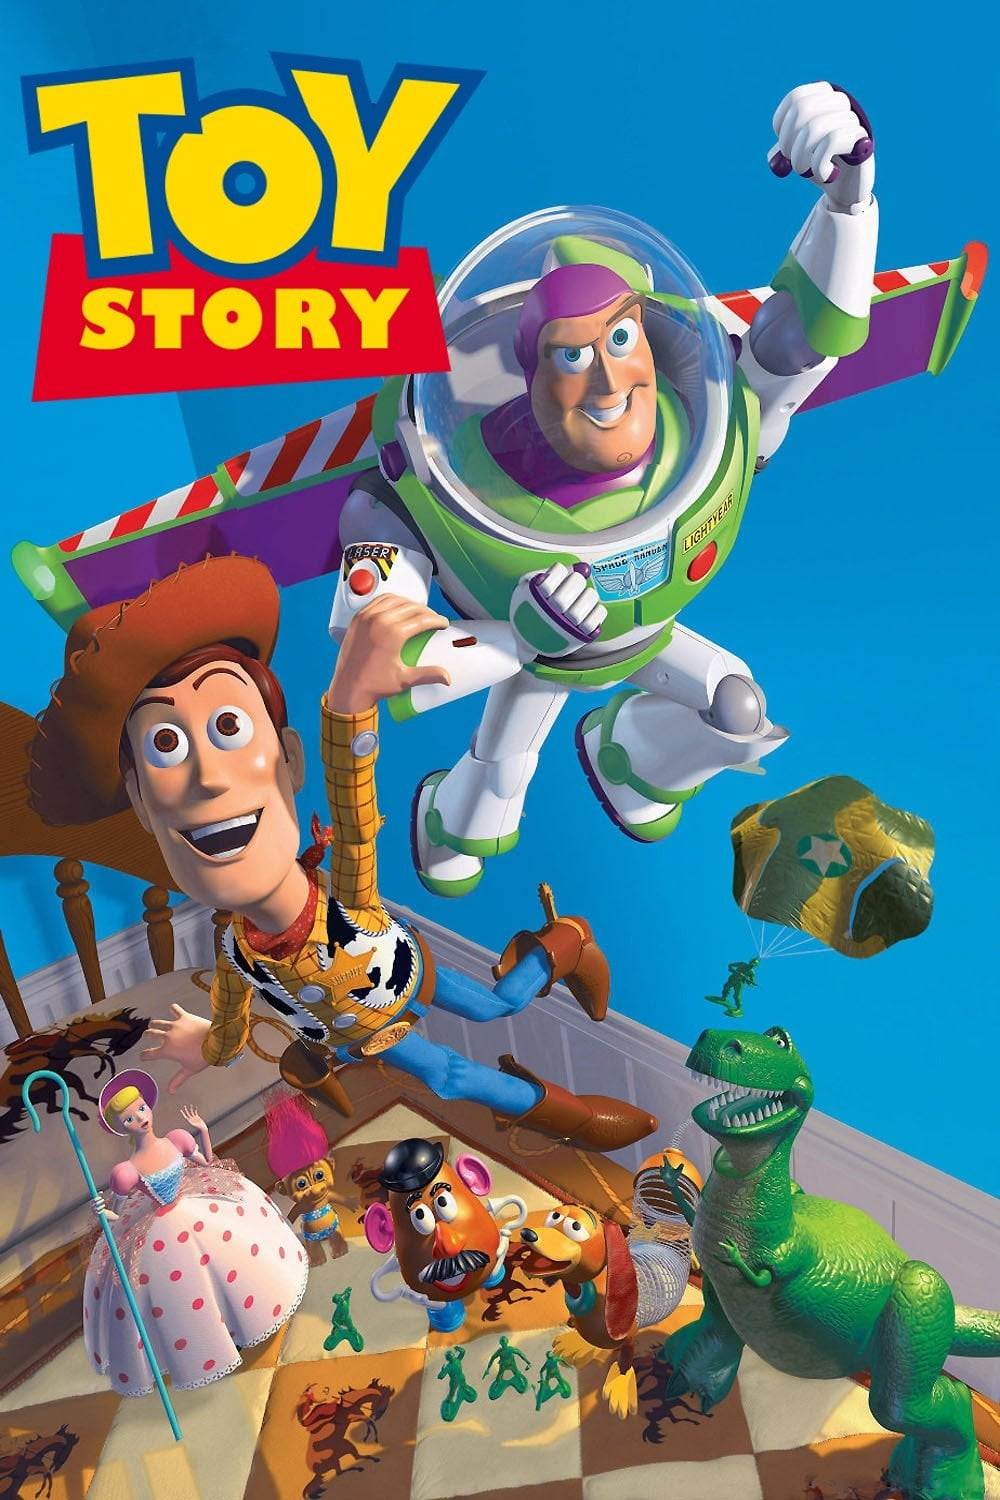

In [158]:
CONFIG_PATTERN = "http://api.themoviedb.org/3/configuration?api_key={api_key}"
config = requests.get(CONFIG_PATTERN.format(api_key = API_KEY)).json()
base_url = config['images']['base_url']
sizes = config['images']['poster_sizes']
def size_str_to_int(x):
  return float("inf") if x == 'original' else int(x[1:])
max_size = max(sizes,key = size_str_to_int)
id = 'tt0114709'
url_format = "http://api.themoviedb.org/3/movie/{imdbid}/images?api_key={api_key}"
response = requests.get(url_format.format(api_key = API_KEY,imdbid = id)).json()
url = "{base_url}{size}{rel_path}".format(base_url = base_url, size = max_size, rel_path = response["posters"][0]["file_path"])
print("url:",url)
r = requests.get(url).content
# display(Image(r))
display(Image(r,width = 200))

In [137]:
get_factor(2628)

[0.031521182507276535,
 0.5885598063468933,
 -0.21230803430080414,
 0.5157657861709595,
 0.4587358832359314,
 0.37330928444862366,
 -0.7208468914031982,
 -0.4458417594432831,
 -0.04007963836193085,
 -0.5133910775184631,
 0.2411598414182663,
 -0.10649711638689041,
 0.304282546043396,
 -0.7600564956665039,
 -0.4985674023628235]

In [0]:
features = get_factor(2628)
formula = "cosineSimilarity(params.query_vector, 'features') + 1.0"
# formula = """
#               double value = dotProduct(params.query_vector, 'features');
#               return sigmoid(1,Math.E, -value);
    
#               """
query = {"query": {
      "script_score": {
          "query": {"match_all": {}},
          "script": {
              "source": formula,
              "params": {"query_vector": features}
          }
      }
    }    
  }
query1 = {"query": {"match_all": {}}}
res = es.search(index = "movie_features", body = query)
# res = es.search(index = "movie_features", body = query)
# movieid = [entry["_source"]["movieid"] for entry in res["hits"]["hits"]]
res

In [164]:
get_similar(get_factor(2628))

[2628, 34150, 135133, 54276, 5459]

In [168]:
id = movie_id_to_imdb(34150)
imdbid = "tt{:07d}".format(int(id))
print(get_title(imdbid))
display_image(get_poster(imdbid))
id

UnboundLocalError: ignored

In [0]:
def get_similar(features, num = 5, item = "movie"):
  # get movie id similar to fetures
  # features could be either user feature (for user recommnedation) or movie feature (find similar movies)
  if item == "movie" or item == "user":
    # user cosine similarity for movie similarity
    formula = "cosineSimilarity(params.query_vector,'features')"
  elif item == "user":
    # use dot product for user reccomendation.
    formula = """
              double value = dotProduct(params.query_vector, 'features');
              return sigmoid(1,Math.E, -value);
    
              """
  query = {"query": {
      "script_score": {
          "query": {"match_all": {}},
          "script": {
              "source": formula,
              "params": {"query_vector": features}
          }
      }
    }    
  }
  res = es.search(index = "movie_features", body = query)
  movieid = [entry["_source"]["movieid"] for entry in res["hits"]["hits"]]
  return movieid[:num]

In [0]:
# define utility functions ot retrieve movie title and posters using TMDB API.
import requests
from IPython.display import Image,display
def get_title(id):
  url_format = "https://api.themoviedb.org/3/find/{external_id}?api_key={api_key}&language=en-US&external_source=imdb_id"
  url = url_format.format(external_id = id,api_key = API_KEY)
  response = requests.get(url).json() # convert to json format
  title = response["movie_results"][0]["title"]
  date = response["movie_results"][0]["release_date"]
  return title,date

def get_poster(id):
  CONFIG_PATTERN = "http://api.themoviedb.org/3/configuration?api_key={api_key}"
  config = requests.get(CONFIG_PATTERN.format(api_key = API_KEY)).json()
  base_url = config['images']['base_url']
  sizes = config['images']['poster_sizes']

  def size_str_to_int(x):
    return float("inf") if x == 'original' else int(x[1:])

  max_size = max(sizes,key = size_str_to_int)

  # get image url
  url_formal = "http://api.themoviedb.ord/3/movie/{imdbid}/images?api_key={api_key}"
  response = requests.get(url_format.format(api_key = API_KEY,imdbid = id)).json()
  url = "{base_url}{size}{rel_path}".format(base_url = base_url, size = max_size, rel_path = response["posters"][0]["file_path"])

  # download image
  r = requests.get(url).content   # convert response to byte strings
  return r

def display_image(bytes,width = 200):
  display(Image(bytes,width = width))

In [0]:
def get_factor(id,item = "movie"):
  # given id of movie or user, return factors of shape (k,)
  if item == "movie":
    query_title = "movieid"
    index_title = "movie_features"
  elif item == "user":
    query_title = "userid"
    index_title = "user_features"
  query = {
      "query":{
          "match": {query_title: id}
      }
  }
  res = es.search(index = index_title, body = query)
  return res["hits"]["hits"][0]["_source"]["features"]

def get_similar(features, num = 5, item = "movie"):
  # get movie id similar to fetures
  # features could be either user feature (for user recommnedation) or movie feature (find similar movies)
  if item == "movie" or item == "user":
    # user cosine similarity for movie similarity
    formula = "cosineSimilarity(params.query_vector,'features')"
  elif item == "user":
    # use dot product for user reccomendation.
    formula = """
              double value = dotProduct(params.query_vector, 'features');
              return sigmoid(1,Math.E, -value);
    
              """
  query = {"query": {
      "script_score": {
          "query": {"match_all": {}},
          "script": {
              "source": formula,
              "params": {"query_vector": features}
          }
      }
    }    
  }
  res = es.search(index = "movie_features", body = query)
  movieid = [entry["_source"]["movieid"] for entry in res["hits"]["hits"]]
  return movieid[:num]

def user_rated_highly(userid):
  # get the top 5 movies that user rated highly
  top_5 = movie_ratings.where(movie_ratings.userId == userid).orderBy("ratings",ascending = False).limit(5).toPandas()
  movieids = top_5["movieId"].tolist()
  return movieids

def movie_id_to_imdb(movieid):
  # convert movieid to imdbid
  query = {
      "query": {
          "match": {"movieId": movieid}
      }
  }
  res = es.search(index = "links", body = query)
  return int(res["hits"]["hits"][0]['_source']['imdbId'])

def show_poster(imdbids):
  # show movie titles and posters with movies inimdb list.
  for id in imdbids:
    try:
      imdbid = "tt{:07d}".format(int(id))
      print(get_title(imdbid))
      display_image(get_poster(imdbid))
    except:
      pass

def recommend_for_user(userid, num = 5):
  # given userid, show all recommended movies and titles if user exist.
  user=  get_factor(userid, item = "user")
  if user == None:
    print("User not found")
    return
  
  user_rated = user_rated_highly(userid)   # top 5 movies taed highly by user
  similar_movieid = get_similar(user,num = num, item = "user")  # top 5 recommendations for user
  user_rated_imdbid = [movie_id_to_imdb(id) for id in user_rated]
  similar_imdbid = [movie_id_to_imdb(id) for id in similar_movieid]

  print("Movies user {} previously rated highly:".format(userid))
  show_poster(user_rated_imdbid)
  print("****************************************")
  print("Recommendation for user {}:".format(userid))
  show_poster(similar_imdbid)

def similar_movie(movieid, num = 5):
  # given movie id, show all recommended movies and titles if user exists.
  movie = get_factor(movieid, item = "movie")
  if movie == None:
    print("Movie not found!")
    return
  similar_movieid = get_similar(movie, num = num + 1,item = "movie")[1:]
  imdbids = [movie_id_to_imdb(id) for id in similar_movieid] # convert movie_id to imdbid

  print("Movies similar to:")
  show_poster([movie_id_to_imdb(movieid)])
  print("**********************************************")
  print("Similar movies: ")
  show_poster(imdbids)

In [170]:
similar_movie(2628)

Output hidden; open in https://colab.research.google.com to view.

In [69]:
imdbid = "tt{:07d}".format(int(120915))
imdbid

'tt0120915'

In [0]:
get_similar(get_factor(2628),6,item = "movie")

In [0]:
def get_similar(features, num = 5, item = "movie"):
  # get movie id similar to fetures
  # features could be either user feature (for user recommnedation) or movie feature (find similar movies)
  if item == "movie" or item == "user":
    # user cosine similarity for movie similarity
    formula = "cosineSimilarity(params.query_vector,'features')"
  elif item == "user":
    # use dot product for user reccomendation.
    formula = """
              double value = dotProduct(params.query_vector, 'features');
              return sigmoid(1,Math.E, -value);
    
              """
  query = {"query": {
      "script_score": {
          "query": {"match_all": {}},
          "script": {
              "scource": formula,
              "params": {"query_vector": features}
          }
      }
    }    
  }
  res = es.search(index = "movie_features", body = query)
  movieid = [entry["_source"]["movieid"] for entry in res["hits"]["hits"]]
  return movieid[:num]

In [0]:
get_factor(2628)

In [61]:
movie_id_to_imdb(2628)

120915

In [0]:
!kill -9 -1
# import sys
# sys.exit()